# Data Loading

In [102]:
import os

def get_file_names(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    # Filter out directories, leaving only files
    file_names = [file for file in files if os.path.isfile(os.path.join(folder_path, file))]
    return file_names

folder_path = './marked_data'
file_names = get_file_names(folder_path)
print("File names in the folder:")
for file_name in file_names:
    print(file_name)
#file_names.pop(-1)

File names in the folder:
result_with_parameters_0.csv
result_with_parameters_1.csv
result_with_parameters_2.csv
result_with_parameters_3.csv
result_with_parameters_4.csv
result_with_parameters_5.csv
result_with_parameters_6.csv
result_with_parameters_7.csv
result_with_parameters_8.csv
result_with_parameters_9.csv


In [104]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = list()
for i, file_name in enumerate(file_names):
    temp = pd.read_csv(f'./marked_data/{file_name}')
    temp = temp.drop(["index", ], axis=1)  # "past_OBV", "upper_ST", "lower_ST"
    data_for_analysis = temp
    y, X = temp["result"], temp.drop(["result"], axis=1)
    data.append([y, X])
    
data[2][1]

,close,open,high,low,volume,EMA_prev_diff,EMA_current_diff,prev_RSI,current_RSI,MACD_prev_diff,...,BB_lower,ST_upper,ST_lower,ATR,StochRSI_K,StochRSI_D,aroon_up,aroon_low,OBV,OBV_MA
0,265.60,266.00,266.32,265.56,43037,0.394850,0.500815,48.555517,47.947169,-0.153055,...,265.448099,270.249327,264.602268,1.467147,6.936416,6.520458,64.0,84.0,234895.0,414988.266667
1,266.01,265.60,266.22,265.56,47928,0.500815,0.560291,47.947169,48.630577,-0.170107,...,265.355440,270.249327,264.602268,1.480004,18.786127,10.470362,60.0,80.0,282823.0,403265.933333
2,266.16,266.00,266.25,266.00,19430,0.560291,0.600243,48.630577,48.878599,-0.144469,...,265.290888,270.249327,264.602268,1.464670,23.121387,11.915449,56.0,76.0,302253.0,392105.200000
3,265.61,266.16,266.18,265.57,40318,0.600243,0.682370,48.878599,48.019941,-0.109682,...,265.143141,270.249327,264.602268,1.474359,7.225434,6.616797,52.0,72.0,261935.0,377324.066667
4,265.46,265.60,265.61,265.11,111626,0.682370,0.768082,48.019941,47.788682,-0.115406,...,264.982253,270.249327,264.602268,1.476069,2.890173,5.171711,48.0,68.0,150309.0,353991.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,260.83,260.85,260.85,260.79,4262,-0.894966,-0.885552,52.965329,52.896306,-0.001767,...,260.738512,253.483302,264.602268,1.133276,9.090909,7.238623,48.0,64.0,445606.0,448695.400000
3076,260.86,260.83,260.88,260.80,10048,-0.885552,-0.878839,52.896306,52.989124,-0.001485,...,260.738476,253.483302,264.602268,1.129724,11.570248,8.065069,44.0,60.0,455654.0,448922.466667
3077,260.85,260.81,260.88,260.80,10302,-0.878839,-0.871140,52.989124,52.953992,0.000694,...,260.738213,253.483302,264.602268,1.126409,10.833333,7.819431,40.0,56.0,445352.0,448139.466667
3078,260.79,260.82,260.86,260.75,14297,-0.871140,-0.858301,52.953992,52.742076,0.001394,...,260.732606,253.483302,264.602268,1.125315,5.833333,6.152764,36.0,52.0,431055.0,446870.466667


In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# get data
divided_data = list()
for data_train in data:
    divided_data.append(train_test_split(data_train[1], data_train[0], test_size=0.20, random_state = 2020, stratify=data_train[0]))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

# Scale Data

In [73]:
import numpy as np
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
for i, data_train in enumerate(divided_data):
    divided_data[i][0] = ss.fit_transform(data_train[0])
    divided_data[i][1] = ss.fit_transform(data_train[1])
    # divided_data[i][0] = data_train[0]
    # divided_data[i][1] = data_train[1]
    
    
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

for i, data_train in enumerate(divided_data):
    X_train_list.append(data_train[0])
    X_test_list.append(data_train[1])
    y_train_list.append(data_train[2])
    y_test_list.append(data_train[3])

X_train_scaled = np.concatenate(X_train_list, axis=0)
X_test_scaled = np.concatenate(X_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

X_train_scaled
# X_train_scaled = ss.fit_transform(X_train)
# X_test_scaled = ss.transform(X_test)
# y_train = np.array(y_train)

array([[-0.0864178 , -0.05478134, -0.08169137, ..., -0.66306867,
        -0.54115965, -0.58170396],
       [ 1.40397531,  1.41336733,  1.38692773, ..., -1.02467914,
         1.25564244,  1.23239093],
       [ 1.51240619,  1.48985553,  1.49319539, ...,  1.5065942 ,
         0.92311815,  0.96985516],
       ...,
       [-0.83012252, -0.85472188, -0.82430518, ..., -1.09193722,
        -0.68273329, -0.68584066],
       [-0.94516183, -0.94787951, -0.94434623, ..., -0.85071463,
        -0.83056852, -0.81969973],
       [ 1.18166246,  1.21999955,  1.21078328, ..., -0.73010334,
         1.27047822,  1.30138917]])

In [106]:
import numpy as np
import pandas as pd

# Assuming 'divided_data' is a list of tuples (X_train, X_test, y_train, y_test)

# Define function to perform EMA scaling for each feature
def ema_scaling(ema_data):
    ema_scaled_data = pd.DataFrame()
    for column in ema_data.columns:
        ema = ema_data[column].ewm(span=288).mean()  # Compute EMA for each column
        ema_scaled_data[column] = ema_data[column] / ema  # Scale each column by its EMA
    return ema_scaled_data

# Perform EMA scaling for each dataset in 'divided_data'
for i, data_train in enumerate(divided_data):
    divided_data[i][0] = ema_scaling(data_train[0])  # Scale training data
    divided_data[i][1] = ema_scaling(data_train[1])  # Scale testing data

# Extract scaled features and labels for training and testing sets
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
for data_train in divided_data:
    X_train_list.append(data_train[0])
    X_test_list.append(data_train[1])
    y_train_list.append(data_train[2])
    y_test_list.append(data_train[3])

# Concatenate scaled features and labels
X_train_scaled = np.concatenate(X_train_list, axis=0)
X_test_scaled = np.concatenate(X_test_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

X_train_scaled

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.01233226, 1.01215205, 1.01215205, ..., 0.66743917, 1.34095803,
        1.35009923],
       [1.00934487, 1.00887734, 1.00920262, ..., 2.17357228, 1.13282802,
        1.15233182],
       ...,
       [0.9239649 , 0.92180053, 0.92449941, ..., 0.09945443, 0.27062479,
        0.2673183 ],
       [0.91376685, 0.91364585, 0.91383791, ..., 0.2998191 , 0.11304103,
        0.12236388],
       [1.1117054 , 1.11542474, 1.11432399, ..., 0.40142629, 2.35398485,
        2.42095971]])

# Over Sampling

In [226]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()
#smote = SMOTE()

# Fit SMOTE to the training data
X_train_scaled, y_train = adasyn.fit_resample(X_train_scaled, y_train)
X_train_scaled

array([[ 0.62708071,  0.70674448,  0.66893331, ...,  0.21449596,
         0.38493435,  0.38508512],
       [ 0.56186488,  0.56939925,  0.53152222, ...,  1.52789133,
         0.48787249,  0.49300678],
       [-0.12652441, -0.14082016, -0.16276539, ...,  1.28909217,
        -1.43700722, -1.42779322],
       ...,
       [-0.64336275, -0.62885709, -0.66398359, ...,  1.25448523,
        -0.75720152, -0.77478978],
       [-0.6323245 , -0.67203493, -0.66981425, ...,  0.7486046 ,
        -0.68406828, -0.67935978],
       [-0.64345032, -0.70413997, -0.70525398, ...,  0.58540076,
        -1.203545  , -1.23532754]])

# Undersempling

In [227]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler()

# Fit undersampler to the training data
X_train_scaled, y_train = undersampler.fit_resample(X_train_scaled, y_train)
X_train_scaled

array([[ 0.56186488,  0.56939925,  0.53152222, ...,  1.52789133,
         0.48787249,  0.49300678],
       [-0.12652441, -0.14082016, -0.16276539, ...,  1.28909217,
        -1.43700722, -1.42779322],
       [ 0.74120841,  0.33446662,  0.70871021, ..., -0.62130109,
         0.38447919,  0.38438185],
       ...,
       [ 0.62668173,  0.62171502,  0.57813486, ..., -0.39188759,
         0.91603675,  0.91587978],
       [ 0.3758022 ,  0.38478864,  0.35094068, ...,  1.46165363,
         0.78608053,  0.82560154],
       [ 0.60062757,  0.59936278,  0.55505786, ..., -0.31367789,
         0.04678043,  0.04658299]])

# Learning

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))
display(rfc.score(X_test_scaled, y_test))

0.999883395522388

0.953061858874728

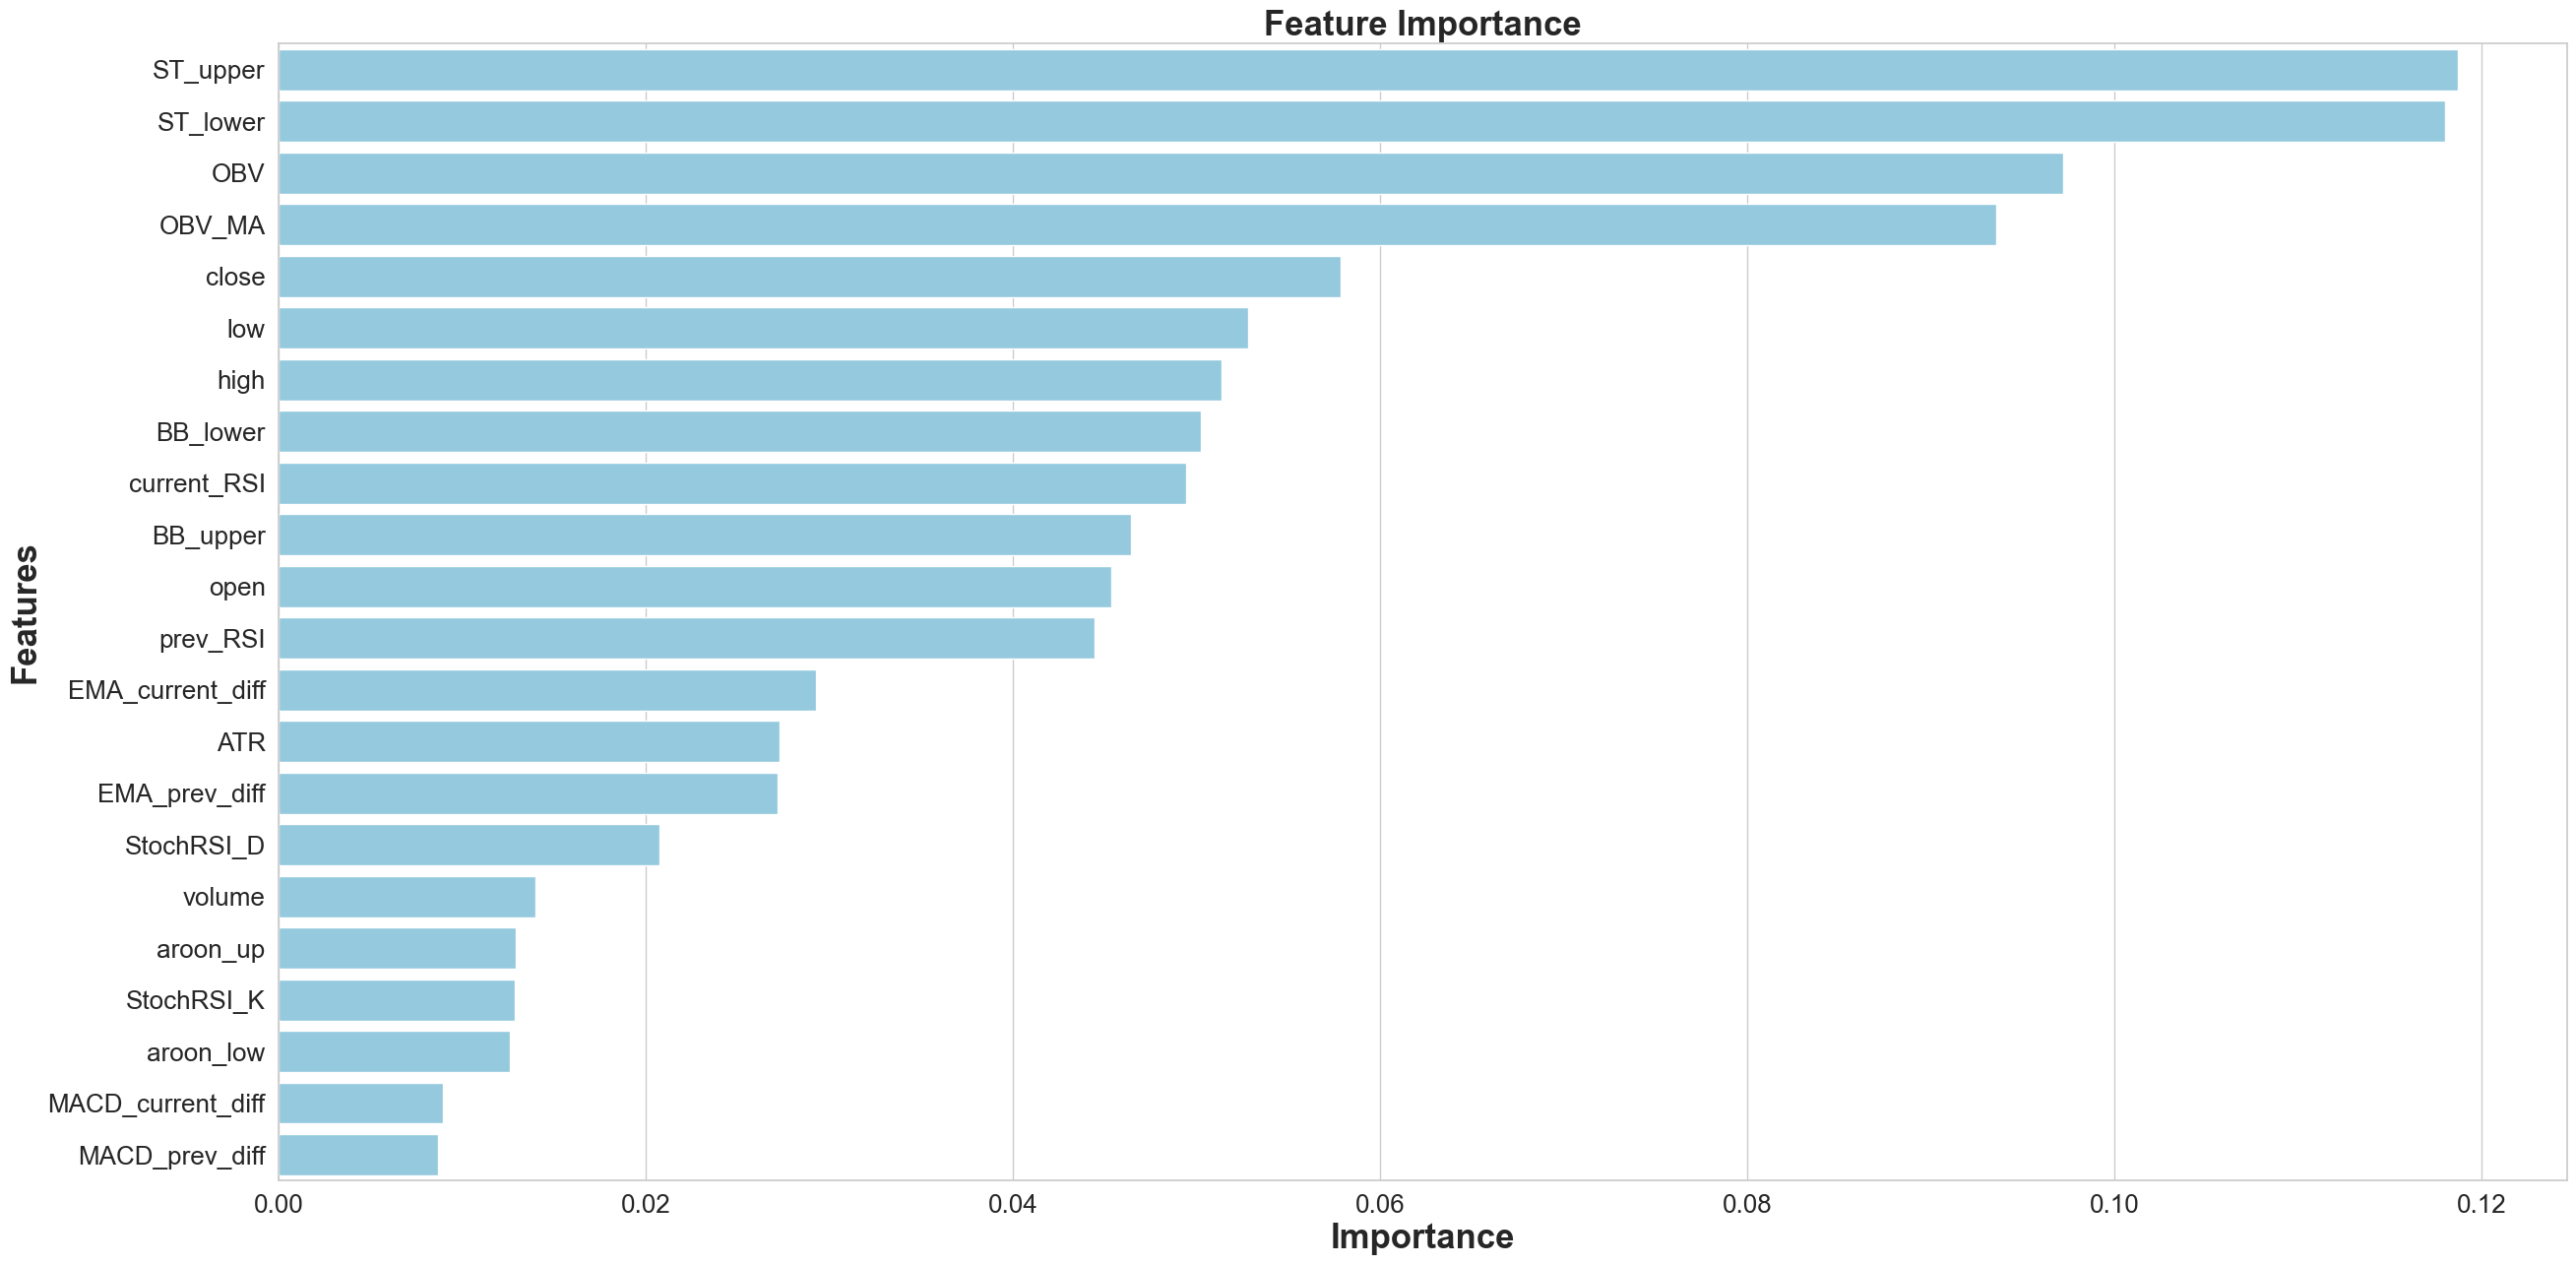

None

,Features,Gini-Importance
0,ST_upper,0.118713
1,ST_lower,0.118011
2,OBV,0.097231
3,OBV_MA,0.093538
4,close,0.057859
5,low,0.052805
6,high,0.051370
7,BB_lower,0.050222
8,current_RSI,0.049454
9,BB_upper,0.046448


In [108]:
from matplotlib import pyplot as plt
import seaborn as sns

feats = {}
for feature, importance in zip(data_for_analysis.drop("result", axis=1).columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_test = PCA(n_components=12)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=12, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(12))

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [212]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100,
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [232]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameters
param_grid = {
    'n_estimators': 600,
    'min_samples_split': 23,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 15,
    'bootstrap': False
}

# Instantiate Random Forest classifier with specified hyperparameters
rf_classifier = RandomForestClassifier(**param_grid)

# Train the model (assuming X_train and y_train are your training data)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=2,
                       min_samples_split=23, n_estimators=600)

In [110]:
"""
just in case
{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}
"""

from sklearn.metrics import confusion_matrix, precision_score

# y_pred_probs = rfc.predict_proba(X_test_scaled)[:, 1]
# 
# new_threshold = 0.5  # Example: setting a higher threshold
# 
# # Adjust the predicted labels based on the new threshold
# y_pred = (y_pred_probs >= new_threshold).astype(int)
y_pred = rfc.predict(X_test_scaled)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
display('Baseline Random Forest recall score', recall_score(y_test, y_pred))
display('Baseline Random Forest precision score', precision_score(y_test, y_pred))

,predicted 0,predicted 1
actual 0,4714,106
actual 1,196,1418


'Baseline Random Forest recall score'

0.8785625774473358

'Baseline Random Forest precision score'

0.9304461942257218

In [132]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = rfc.predict(X_test_scaled)

# Assuming y_test, y_pred are both three-dimensional arrays or lists
# You need to calculate confusion matrices and scores for each class

conf_matrices = []
precision_scores = []
recall_scores = []

for class_label in [-1, 0, 1]:
    y_test_class = (y_test == class_label).astype(int)
    y_pred_class = (y_pred == class_label).astype(int)
    
    conf_matrix_class = confusion_matrix(y_test_class, y_pred_class)
    conf_matrices.append(conf_matrix_class)
    
    precision_score_class = precision_score(y_test_class, y_pred_class, average='binary')
    precision_scores.append(precision_score_class)
    
    recall_score_class = recall_score(y_test_class, y_pred_class, average='binary')
    recall_scores.append(recall_score_class)

# Display the confusion matrices
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Confusion matrix for class {class_label}:')
    display(pd.DataFrame(conf_matrices[idx], index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1']))

# Display precision scores
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Precision score for class {class_label}: {precision_scores[idx]}')

# Display recall scores
for idx, class_label in enumerate([-1, 0, 1]):
    print(f'Recall score for class {class_label}: {recall_scores[idx]}')

Confusion matrix for class -1:


,predicted 0,predicted 1
actual 0,25176,3586
actual 1,98,855


Confusion matrix for class 0:


,predicted 0,predicted 1
actual 0,1648,262
actual 1,12513,15292


Confusion matrix for class 1:


,predicted 0,predicted 1
actual 0,19714,9044
actual 1,281,676


Precision score for class -1: 0.1925242062598514
Precision score for class 0: 0.9831554584029831
Precision score for class 1: 0.06954732510288066
Recall score for class -1: 0.8971668415529905
Recall score for class 0: 0.5499730264340946
Recall score for class 1: 0.7063740856844305


In [78]:
from joblib import dump

model_filename = 'random_forest_model.joblib'
dump(rfc, model_filename)

['random_forest_model.joblib']

# Gradient Boosting model

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score
import xgboost as xgb

# Create a Gradient Boosting Classifier instance
gbm = xgb.XGBClassifier()

# Fit the model to the training data
gbm.fit(X_train_scaled, y_train)

# Evaluate the model on the training and test data
train_score = gbm.score(X_train_scaled, y_train)
test_score = gbm.score(X_test_scaled, y_test)

print("Training Accuracy:", train_score)
print("Test Accuracy:", test_score)

Training Accuracy: 0.9936644900497512
Test Accuracy: 0.9103201740752254


In [68]:
# Calculate recall score on the test data
y_pred_test = gbm.predict(X_test_scaled)
recall = recall_score(y_test, y_pred_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred_test), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

display(conf_matrix_baseline)
print("Test Recall Score:", recall)
display('Test precision score', precision_score(y_test, y_pred_test))

,predicted 0,predicted 1
actual 0,3915,167
actual 1,410,1942


Test Recall Score: 0.8256802721088435


'Test precision score'

0.9208155523944997

In [196]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = gbm.predict(X_test_scaled)

# Assuming y_test, y_pred are both three-dimensional arrays or lists
# You need to calculate confusion matrices and scores for each class

conf_matrices = []
precision_scores = []
recall_scores = []

for class_label in [0, 1, 2]:
    y_test_class = (y_test == class_label).astype(int)
    y_pred_class = (y_pred == class_label).astype(int)
    
    conf_matrix_class = confusion_matrix(y_test_class, y_pred_class)
    conf_matrices.append(conf_matrix_class)
    
    precision_score_class = precision_score(y_test_class, y_pred_class, average='binary')
    precision_scores.append(precision_score_class)
    
    recall_score_class = recall_score(y_test_class, y_pred_class, average='binary')
    recall_scores.append(recall_score_class)

# Display the confusion matrices
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Confusion matrix for class {class_label}:')
    display(pd.DataFrame(conf_matrices[idx], index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1']))

# Display precision scores
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Precision score for class {class_label}: {precision_scores[idx]}')

# Display recall scores
for idx, class_label in enumerate([0, 1, 2]):
    print(f'Recall score for class {class_label}: {recall_scores[idx]}')

Confusion matrix for class 0:


,predicted 0,predicted 1
actual 0,8786,19972
actual 1,140,817


Confusion matrix for class 1:


,predicted 0,predicted 1
actual 0,24544,4218
actual 1,56,897


Confusion matrix for class 2:


,predicted 0,predicted 1
actual 0,1833,77
actual 1,24071,3734


Precision score for class 0: 0.03929962961181394
Precision score for class 1: 0.175366568914956
Precision score for class 2: 0.9797953293098924
Recall score for class 0: 0.8537095088819227
Recall score for class 1: 0.9412381951731374
Recall score for class 2: 0.13429239345441468


In [186]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Instantiate the GBM classifier
gbm = GradientBoostingClassifier()

scorer = make_scorer(precision_score)

# Instantiate GridSearchCV with precision as the scoring metric
grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring=scorer, n_jobs=-1)

# Perform Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate on test set
test_score = grid_search.score(X_train_scaled, y_test)
print("Test Accuracy:", test_score)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}


ValueError: Found input variables with inconsistent numbers of samples: [12243, 88996]

In [192]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate on test set
test_score = grid_search.score(X_test_scaled, y_test)
print("Test Accuracy:", test_score)

y_pred_test = grid_search.predict(X_test_scaled)

display(conf_matrix_baseline)
print("Test Recall Score:", recall_score(y_test, y_pred_test))
display('Test precision score', precision_score(y_test, y_pred_test))

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Test Accuracy: 0.15275634731378876


,predicted 0,predicted 1
actual 0,7439,3671
actual 1,161,972


Test Recall Score: 0.9611650485436893


'Test precision score'

0.15275634731378876